# Results of simulation of different fairness policies

These experiments use accumulated deficits to try to ensure that applications always receive their computed allocation of GPU time, even in the event of new jobs coming in and old jobs finishing, by keeping track of the difference between the GPU time the application should have received, and the GPU time the application actually received. Allocation of jobs to GPUs is performed in a round-based fashion, with GPUs instructed to run jobs for a fixed interval of time on all GPUs.

# Import statements

In [1]:
# Imports for plotting.
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
sns.set_style('ticks')
font = {
    'font.family':'Roboto',
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=2,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
# Other imports.
import os
import pickle
import re

# Get logfile paths

In [3]:
def get_logfile_paths_helper(directory_name):
    logfile_paths = []
    for root, _, file_names in os.walk(directory_name):
        if len(file_names) > 0:
            logfile_paths.extend(
                [os.path.join(root, file_name)
                 for file_name in file_names])
    return logfile_paths

def get_logfile_paths(directory_name):
    logfile_paths = []
    for logfile_path in get_logfile_paths_helper(directory_name):
        m = re.match(
            r'.*v100=(\d+)\.p100=(\d+)\.k80=(\d+)/(.*)/seed=(\d+)/'
             'lambda=(\d+\.\d+)\.log', logfile_path)
        if m is None: continue
        v100s = int(m.group(1))
        p100s = int(m.group(2))
        k80s = int(m.group(3))
        policy = m.group(4)
        seed = int(m.group(5))
        l = float(m.group(6))
        logfile_paths.append((v100s, p100s, k80s, policy, seed,
                              l, logfile_path))
    return logfile_paths

In [4]:
labels = {"max_min_fairness_water_filling": "LAS",
          "max_min_fairness_water_filling_perf": "LAS+perf"}

# Plotting functions

In [5]:
def prune(logfile_paths, v100s, p100s, k80s, policy, seed=None):
    if seed is None:
        return sorted([(x[5], x[6], x[4]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy])
    else:
        return sorted([(x[5], x[6]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy and
                       x[4] == seed])

In [6]:
def plot_metric_vs_inverse_lambda(logfile_paths,
                                  v100s, p100s, k80s,
                                  policies, metric_fns,
                                  metric_fn_labels,
                                  metric_label,
                                  xmin=0,
                                  xmax=None,
                                  ymin=0,
                                  ymax=None,
                                  output_filename=None):
    plt.figure(figsize=(6, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    data = {"input_job_rate": [], "metric": [], "seed": [],
            "policy": []}
    for policy in policies:
        relevant_logfile_paths = list(reversed(prune(
            logfile_paths, v100s, p100s, k80s, policy)))
        for metric_fn_label, metric_fn in zip(metric_fn_labels, metric_fns):
            lambdas = [x[0] for x in relevant_logfile_paths]
            input_job_rates = [3600.0 / x for x in lambdas]
            metrics = [metric_fn(x[1]) for x in relevant_logfile_paths]
            seeds = [x[2] for x in relevant_logfile_paths]
            policies = [labels[policy] + " (%s)" % metric_fn_label
                        for i in range(len(metrics))]

            import pandas as pd
            data["input_job_rate"] += input_job_rates
            data["metric"] += metrics
            data["seed"] += seeds
            data["policy"] += policies

    sns.lineplot(x='input_job_rate', y='metric', style='policy',
                 hue='policy',
                 data=data, ci='sd',
                 markers=True)

    ax.set_xlabel("Input job rate (jobs/hr)")
    ax.set_ylabel(metric_label)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    sns.despine()
    
    leg = plt.legend(frameon=False)
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    bb.y0 += 0.22
    bb.y1 += 0.22
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)
    
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    plt.show()

In [7]:
def average_jct_low_priority_fn(logfile_path, min_job_id=None,
                                max_job_id=None):
    job_completion_times = []
    with open(logfile_path, 'rb') as f:
        f.seek(-8192, os.SEEK_END)
        text = f.read().decode('utf-8')
        lines = text.split('\n')
        for line in lines[-5:]:
            m = re.match(r'Average job completion time \(low priority\): (\d+\.\d+) seconds', line)
            if m is not None:
                return float(m.group(1)) / 3600
    return None

In [8]:
def average_jct_high_priority_fn(logfile_path, min_job_id=None,
                                 max_job_id=None):
    job_completion_times = []
    with open(logfile_path, 'rb') as f:
        f.seek(-8192, os.SEEK_END)
        text = f.read().decode('utf-8')
        lines = text.split('\n')
        for line in lines[-5:]:
            m = re.match(r'Average job completion time \(high priority\): (\d+\.\d+) seconds', line)
            if m is not None:
                return float(m.group(1)) / 3600
    return None

# Plot average JCT versus input job rate for multi-GPU traces

In [9]:
multigpu_logfile_paths = sorted(get_logfile_paths(
    "/lfs/1/deepak/gpusched/scheduler/logs/multi_gpu_continuous_jobs_priorities_final/"))

V100s=36, P100s=36, K80s=36; Jobs 4000-5000


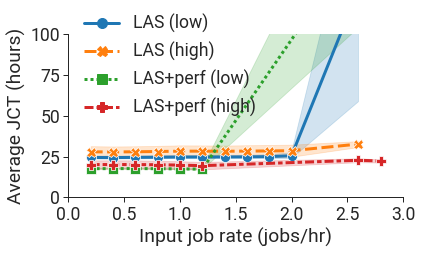

In [10]:
print("V100s=36, P100s=36, K80s=36; Jobs 4000-5000")
plot_metric_vs_inverse_lambda(
    multigpu_logfile_paths,
    v100s=36, p100s=36, k80s=36,
    policies=["isolated",
              "max_min_fairness_water_filling", "max_min_fairness_water_filling_perf"],
    metric_fns=[lambda x: average_jct_low_priority_fn(
                    x, min_job_id=4000, max_job_id=5000),
                lambda x: average_jct_high_priority_fn(
                    x, min_job_id=4000, max_job_id=5000)],
    metric_fn_labels=["low", "high"],
    metric_label="Average JCT (hours)",
    xmax=3.0,
    ymax=100.0,
    output_filename="continuous_jobs/multi_gpu_las_priorities_v100=36_p100=36_k80=36.pdf"
)